In [12]:
import deribit_data as dm
import pandas as pd
import numpy as np
import datetime
import json
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import linear_model
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import clear_output

# Définitions de fonctions

Commençons par définir un certain nombre de fonctions utiles pour le traitement de la donnée, il sagit essentiellement de fonctions pour la conversion entre dates et timestamp

In [2]:
def somme_ponderee(X):
    """
    Input: str représentant une liste de listes de floats = '[[a1,b1],[a2,b2],...,[an,bn]]'
    Output: (Somme des ak*bk) / (Somme des bk)
    """
    s = 0
    d = 0
    
    for x in json.loads(X):

        if len(x)<2:
            return 0.0
        s += x[0]*x[1]
        d += x[1]
    if d!= 0:
        s/= d
    else:
        return 0.0
    return s

def string_to_dict(s):
    """
    Input: str représentant un dictionnaire
    Output: Le dit dictionnaire
    """
    json_acceptable_string = s.replace("'", "\"").replace("None","0.0")
    return json.loads(json_acceptable_string)

def to_date(ts):
    """
    Input: timestamp = nombre de secondes depuis le 01/01/1970
    Output: date
    """
    return str(datetime.datetime.fromtimestamp(ts))


def to_ts(date):
    """
    Input: Date, au format {dd/mm/yy, yy-mm-dd, 13DEC21}
    Output: timestamp en secondes
    """

    
    if '/' in date: #Format dd/mm/yy
        return int(time.mktime(datetime.datetime.strptime(date, "%d/%m/%Y").timetuple()))
    elif '-' in date: #Format yy-mm-dd
        return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()))
    else: # FORMAT 13DEC21
        if len(date)<7:
            date = '0'+date

            
        day = date[:2]
        year = date[-2:]
        month = date[2:-2]

        month_d = { 'JAN':'01',
                    'FEB':'02',
                    'MAR':'03',
                    'APR':'04',
                    'MAY':'05',
                    'JUN':'06',
                    'JUL':'07',
                    'AUG':'08',
                    'SEP':'09',
                    'OCT':'10',
                    'NOV':'11',
                    'DEC':'12'}


        return to_ts(day+'/'+month_d[month]+'/20'+year)
    
def ms_to_s(ts):
    """
    Input: timestamp en ms
    Outpu: timestamp en s
    """
    return int(ts/1000)

def ts_to_days(ts):
    """
    Input: timestamp en s
    Output: nombre de jours, float
    """
    return ts/(3600*24)


# Data processing
## 1 - Récupération de la data sur Deribit

In [3]:
#btc_data = dm.Options("BTC")
#btc_data.collect_data(save_csv=True)




## 2 - Data extraction

In [4]:
# Pre-loading downloaded data
btc_df = pd.read_csv("btc_options_data-2021_Jun_10-10_19_01.csv", index_col=0)
btc_df['mid_iv'] = (btc_df.bid_iv + btc_df.ask_iv)/2

btc_df['V'] = [x['volume'] for x in btc_df['stats'].apply(string_to_dict)]




Le plus simple est de définir une pipeline de traitement, pour avoir des DataFrames prêts à l'utilisation ensuite.

In [5]:
def pipeline(df):
    

    #### Ajout des Strikes K et des dates de maturité _T 
    EXP_DATES, STRIKES = [], []
    for inst_name in df['instrument_name']:
        el = inst_name.split('-')
        EXP_DATES.append(el[1])
        STRIKES.append(el[2])
    
    df = df.assign( _T = EXP_DATES)
    df = df.assign( K = STRIKES)

    #Equivalent a : 
    #df['K'] = STRIKES
    #df['_T'] = EXP_DATES
    

    
    
    #### Ajout des bids/asks/mid
    df['bids'] = df['bids'].apply(somme_ponderee)
    df['asks'] = df['asks'].apply(somme_ponderee)
    df['mid'] = (df.bids+df.asks)/2
    

    #### Supression des lignes ou les IV sont nulles et où les Volumes sont nuls
    df = df.drop(df[df.mid_iv == 0.0].index)
    df = df.drop(df[df.V == 0.0].index)
    
    #### Supression des lignes ou les IV sont nulles et où les Volumes sont nuls
    moy_volumes = sum(df.V)/len(df.V)
    var_volumes = np.sqrt(sum((np.array(df.V)-moy_volumes)**2)/len(df.V))
    min_acceptable_volume= moy_volumes-0.7*var_volumes
    
    print("moy_volumes = ", moy_volumes)
    print("var_volumes = ", var_volumes)
    print("min_acceptable_volume = ", min_acceptable_volume)
    
    df = df.drop(df[df.V <= min_acceptable_volume].index)
    
    #### Changement de _T pour le nombre de jours restants avant l'expiration du contrat (à partir du call de la fonction)
    df['_T'] = df['_T'].apply(to_ts) - datetime.datetime.timestamp(datetime.datetime.today())#btc_subset['timestamp'].apply(ms_to_s)
    df['_T'] = df['_T'].apply(ts_to_days)
    
    #### Ajout du prix du sous-jacent 
    df['S'] = df['underlying_price']
    
    #### Tri selon les Strikes croissants
    df = df.sort_values('K')



    final_df = df[['S','K','V', '_T', 'mid_iv','bids','asks','last_price','mid']]

    return final_df

#btc_data.head()
    

In [6]:
btc_call = pipeline(btc_df[btc_df.option_type == 'C'])
btc_put  = pipeline(btc_df[btc_df.option_type == 'P'])

btc_call = btc_call.astype(float)

moy_volumes =  80.16910569105691
var_volumes =  138.6470228015031
min_acceptable_volume =  -16.883810269995266
moy_volumes =  83.03465346534654
var_volumes =  120.7861742429416
min_acceptable_volume =  -1.515668504712579


In [7]:
btc_call.tail(200)

,S,K,V,_T,mid_iv,bids,asks,last_price,mid
400,38890.92,100000.0,0.6,283.723124,97.625,0.060794,0.098212,0.0950,0.079503
268,36895.86,100000.0,0.1,10.681457,88.965,0.000000,0.017171,0.0005,0.008586
336,37055.68,100000.0,2.0,45.681457,117.765,0.000805,0.009361,0.0025,0.005083
197,37591.02,100000.0,47.3,101.681457,102.235,0.005908,0.260719,0.0140,0.133314
385,38301.58,100000.0,55.1,199.723124,99.870,0.029876,0.193403,0.0530,0.111640
...,...,...,...,...,...,...,...,...,...
186,37321.87,80000.0,1.1,73.681457,97.335,0.008716,0.016342,0.0140,0.012529
48,36896.27,80000.0,13.0,10.681457,148.880,0.000500,0.013062,0.0005,0.006781
379,37590.07,88000.0,50.9,101.681457,99.005,0.009392,0.104991,0.0195,0.057191
345,37326.18,90000.0,28.0,73.681457,100.590,0.006607,0.013826,0.0070,0.010217


In [8]:
#btc_put.head()

In [9]:
#btc_call.to_csv("btc_call.csv")
#btc_put.to_csv("btc_put.csv")
#btc_call.to_excel("btc_call.xlsx")
#btc_put.to_excel("btc_put.xlsx")

# Plotting des fonctions

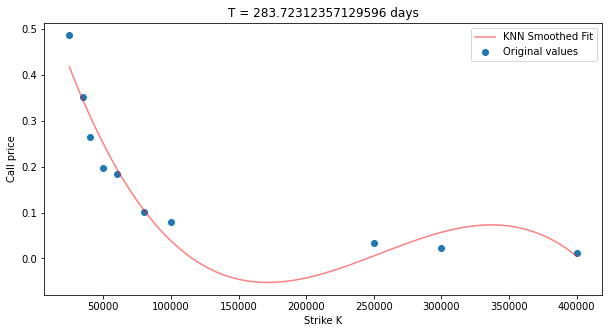

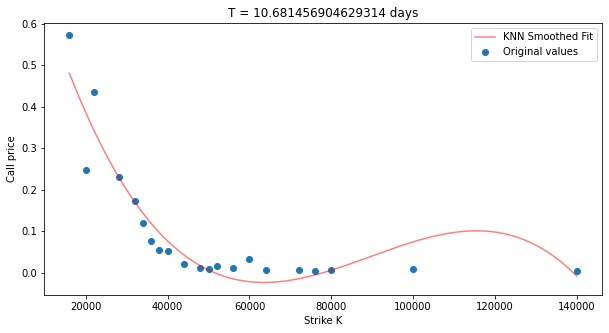

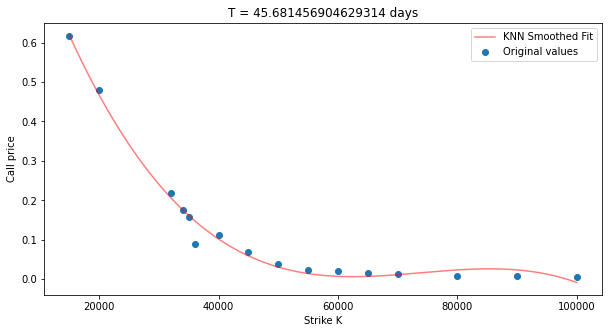

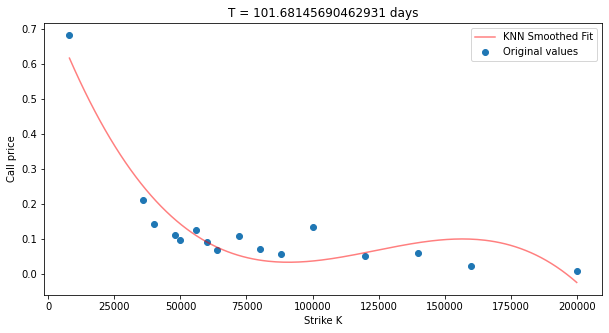

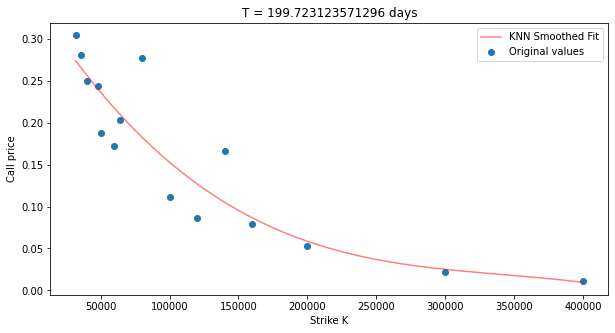

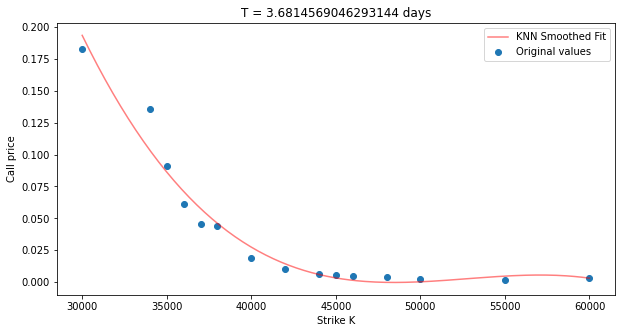

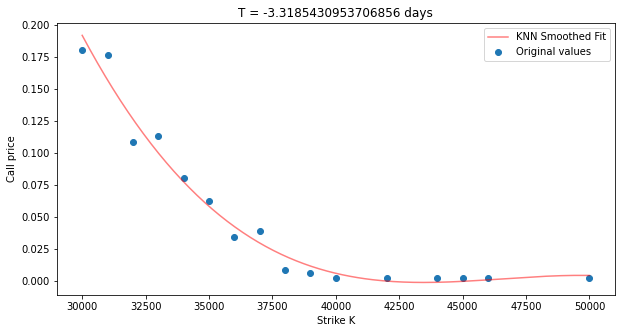

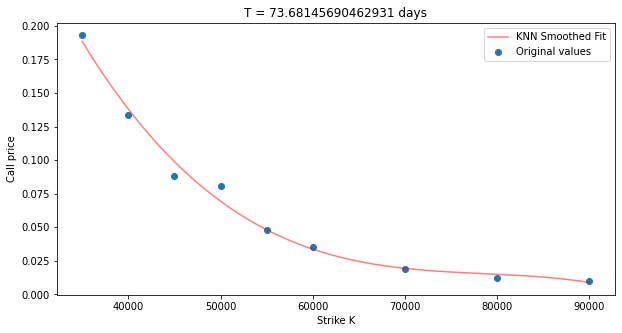

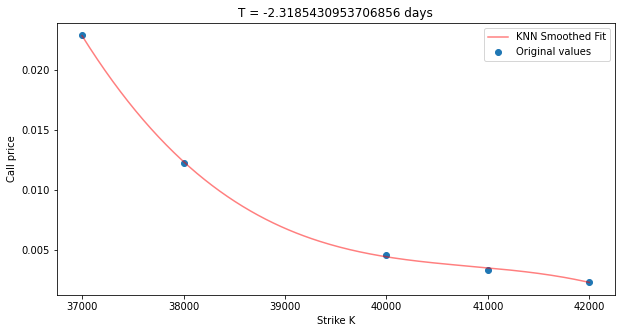

In [10]:
btc_data = btc_call

res = []
for i in list(btc_data['_T']):
    if i not in res:
        res.append(i)

plt.rcParams["figure.figsize"] = (10,5)

for T in res:
    
    X = btc_data[btc_data._T == T].K
    
    Y = btc_data[btc_data._T == T].mid
    

    plt.xlabel('Strike K')
    plt.ylabel('Call price')
    plt.title('T = {} days'.format(T))
    


    nb_degree = 3
    
    polynomial_features = PolynomialFeatures(degree = nb_degree)
    X_TRANSF = polynomial_features.fit_transform(X.values.reshape(-1,1))
    model = LinearRegression()
    model.fit(X_TRANSF, Y.values.reshape(-1,1))
    
    X_NEW = X.values.reshape(-1,1)
    
    X_NEW = np.linspace(min(list(X)), max(list(X)), num=int(200)).reshape(-1,1)
    
    X_NEW_TRANSF = polynomial_features.fit_transform(X_NEW)
    Y_NEW = model.predict(X_NEW_TRANSF)
    
    
    
    
    plt.plot(X_NEW, Y_NEW, c='r', alpha=0.50, label='KNN Smoothed Fit')
    plt.scatter(X, Y, label = "Original values") #label='Mid Implied Volatility')
    plt.legend()
    plt.show()


    


On peut faire de même en affichants C(T) pour différentes valeurs du strike, cependant on va plutôt essayer d'afficher directement un nuage de points de 3D représenant C(K,T).

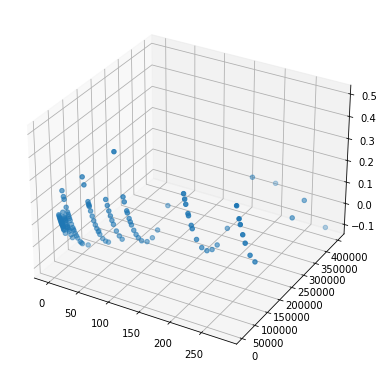

,_T,K
400,283.723124,100000.0
268,10.681457,100000.0
336,45.681457,100000.0
197,101.681457,100000.0
385,199.723124,100000.0


In [35]:
# TEST AVEC LES DEUX VAR

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
axes = Axes3D(fig)

x = btc_data[['_T','K']].astype(float)
y = btc_data['mid'].astype(float) #ou last_price ?


regr = linear_model.LinearRegression()
regr.fit(x,y)


nb_degree = 3
polynomial_features = PolynomialFeatures(degree = nb_degree)
X_TRANSF = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(X_TRANSF, y.values.reshape(-1,1))

X_NEW = x
#X_NEW = np.linspace(min(list(X)), max(list(X)), num=int(200)).reshape(-1,1)

X_NEW_TRANSF = polynomial_features.fit_transform(X_NEW)
Y_NEW = model.predict(X_NEW_TRANSF)
axes.scatter(list(x['_T']),list(x['K']),Y_NEW)
plt.show()


x.head(5)

Nous allons maintenant avoir besoin d'une fonction du prix des calls $C : K,T -> \mathbb{R} $ qui est $C^1$ pour pouvoir l'estimer en $k+h$ ainsi qu'en $t+h$ pour avoir les dérivées partielles nécessaires aux calcul de la volatilité locale.

Pour cela je propose d'effectuer une régression polynomiale de degré $n = 3$ sur le prix des calls que nous avons déjà 

In [51]:
class Call:
    def __init__(self,df):
        
        self.model = LinearRegression()

        self.polynomial_features = PolynomialFeatures(degree = 3)
        
        x = df[['_T','K']].astype(float)
        y = df['mid'].astype(float)      #ou last_price ?
        
        
        x_transformed = polynomial_features.fit_transform(x)
        
        self.model.fit(x_transformed, y.values.reshape(-1,1))
        
        self.S0 = list(df['S'])[0]
        #print('S0 = {}'.format(self.S0))
        
    def C(self,K,T):
        #x = pd.DataFrame(np.array([K],[T]), columns = ['K','_T'])

        d = { '_T': [T], 'K': [K]}
        x = pd.DataFrame(data=d)

        X_NEW = self.polynomial_features.fit_transform(x)
        
        return float(np.squeeze(self.model.predict(X_NEW)))
    
        

Pour avoir le pricer il suffit donc dans un premier temps de charger le dataframe $btc\_call$ dans la classe $Call$



In [54]:
call = Call(btc_call)
print("S0 = ${}".format(call.S0))

S0 = $38890.92


Puis le prix d'un call de strike $K$ et de maturité $T$ est obtenu en appellant la méthode $C$ de la classe $Call$ comme ceci :

In [61]:
K = 31000.0
T = 0.271374
price = call.C(K ,T)
print("${}".format(round(price*call.S0,2)))

$4414.64


In [47]:
btc_call.tail(5)

,S,K,V,_T,mid_iv,bids,asks,last_price,mid
186,37321.87,80000.0,1.1,73.681457,97.335,0.008716,0.016342,0.0140,0.012529
48,36896.27,80000.0,13.0,10.681457,148.880,0.000500,0.013062,0.0005,0.006781
379,37590.07,88000.0,50.9,101.681457,99.005,0.009392,0.104991,0.0195,0.057191
345,37326.18,90000.0,28.0,73.681457,100.590,0.006607,0.013826,0.0070,0.010217
89,37032.66,90000.0,1.5,45.681457,113.410,0.002272,0.011919,0.0035,0.007096


Maintenant on peut facilement définir des fonctions pour $\frac{\partial C}{\partial K}$ et $\frac{\partial C}{\partial T}$, et on obtient la volatilité locale $\sqrt{ \frac {2 \frac{\partial C}{\partial T} +rK \frac{\partial C}{\partial K}}{K^2 \frac{\partial ^2 C}{\partial K^2}}}$

In [81]:
def dC_dK(C,K,T, h=1e-2):

    return (C(K+h, T) -  C(K,T))/h

def d2C_dK2(C,K,T, h=1e-2):
    val = (dC_dK(C,K+h, T) -  dC_dK(C,K,T))/h
    return val


def dC_dT(C,K,T, h=1e-2):
    val = (C(K, T+h) -  C(K,T))/h
    
    return val

def local_vol(C,K,T):
    r = 0.003
    num = 2*(dC_dT(C,K,T) + r*K* dC_dK(C,K,T))
    denom = K**2 * d2C_dK2(C,K,T)
    frac = num/denom

    return np.sqrt(frac)
    

In [82]:
print(dC_dK(call.C, K, T))
print(dC_dT(call.C, K, T))
print("=================")
print(d2C_dK2(call.C, K, T))

-6.224006793287273e-06
0.00252344555814743
9.686695889854491e-11


On peut afficher la surface des volatilités, pour $K$ allant de $K_{min}$ à $K_{max}$ en $n_K$ points. Idem pour $T$.

In [164]:
K_min = 30000
K_max = 35000
n_K = 50
T_min = 0
T_max = 40
n_T = 50

Ks = np.linspace(K_min,K_max,n_K)
Ts = np.linspace(T_min,T_max,n_T)


Il faut ensuite vectoriser la fonction $local\_vol$ pour l'appliquer a chaque coordonnées du vecteur $[K,T]$, cette étape demande un certain temps d'execution.

In [165]:
X, Y = np.meshgrid(Ks, Ts)

start = time.process_time()

Z = np.vectorize(local_vol)(call.C,X,Y)

print("calculé en {}s".format(time.process_time()-start))
print(Z)


calculé en 96.69109600000002s
[[0.2114958  0.21094708 0.21070353 ... 0.1795105  0.17992843 0.1782519 ]
 [0.21088299 0.21003716 0.20949418 ... 0.17844961 0.1788585  0.17823072]
 [0.20997179 0.20972232 0.20947905 ... 0.17790721 0.17779526 0.17768801]
 ...
 [0.1832912  0.18332602 0.18283156 ... 0.1544444  0.15387649 0.15354073]
 [0.1826001  0.18157523 0.18214059 ... 0.15383001 0.15418419 0.15270084]
 [0.18243665 0.18167461 0.18091791 ... 0.15344235 0.15310545 0.15141337]]


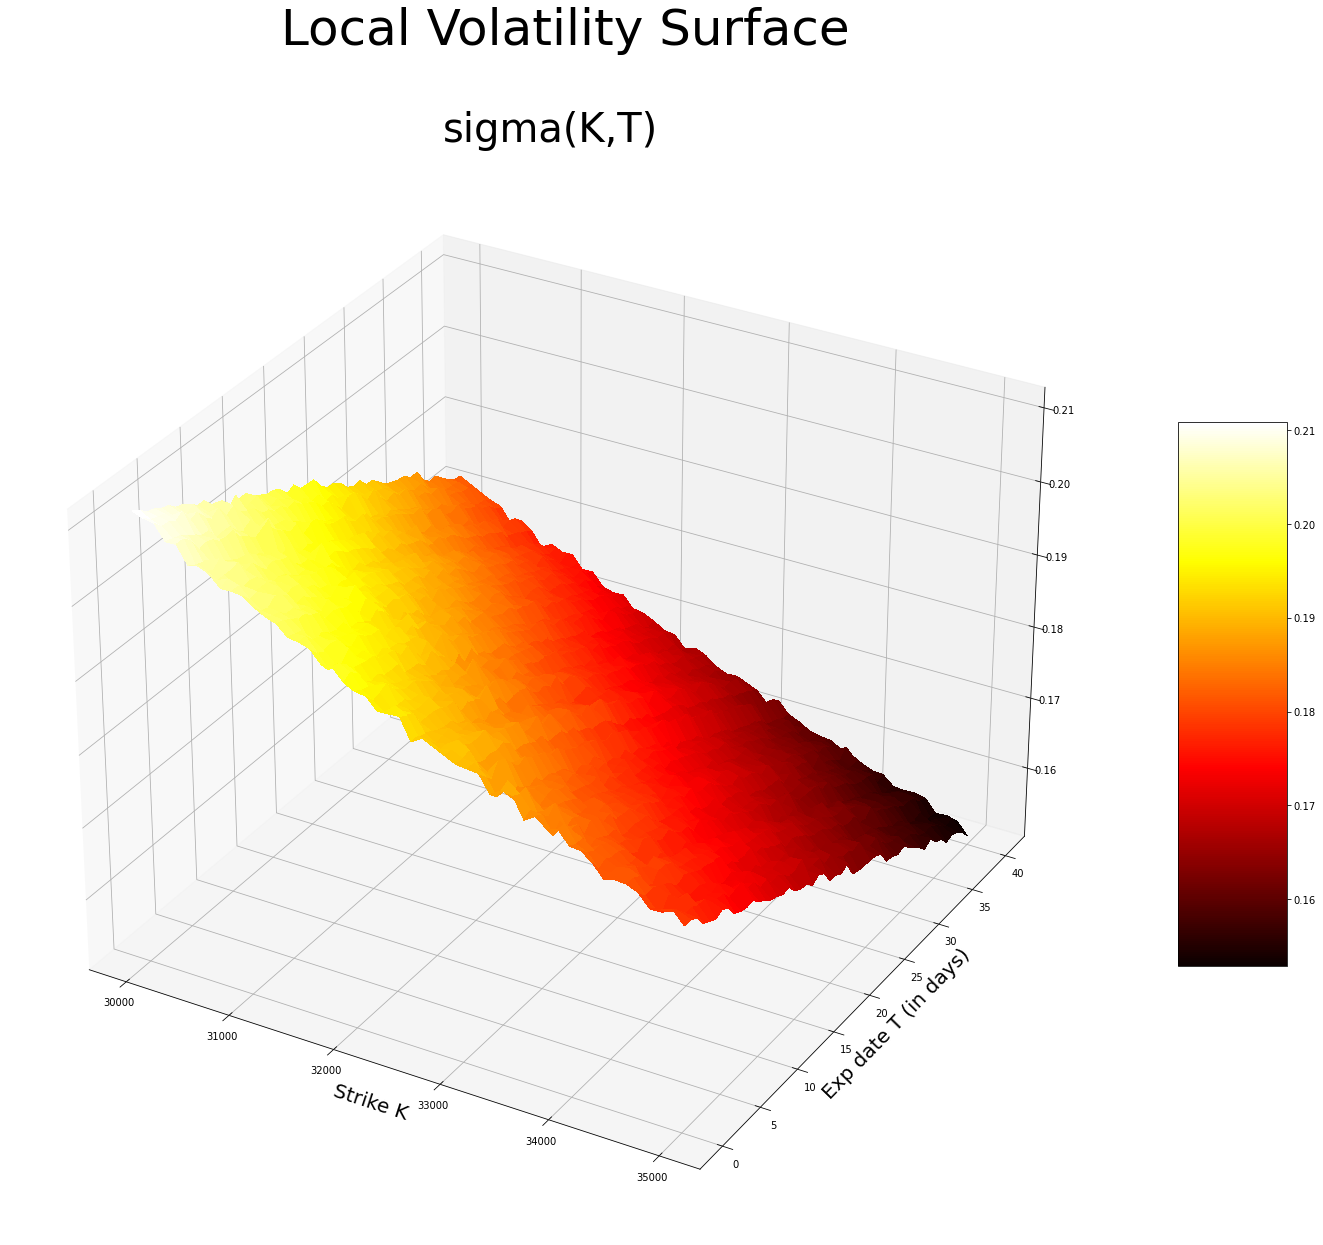

In [166]:
fig = plt.figure(figsize=(30,20))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#surf = ax.scatter3D(X, Y, Z, s = .5, cmap='hot')
#surf = ax.plot_wireframe(X, Y, Z)
#surf = ax.contour3D(X, Y, Z, cmap='binary')
#ax.set_zlim(-1.01, 1.01)

fig.colorbar(surf, shrink=0.5, aspect=5)


fig.suptitle('Local Volatility Surface', fontsize=50)
plt.title('sigma(K,T)', fontsize = 40)
plt.xlabel('Strike K', fontsize=20)
plt.ylabel('Exp date T (in days)', fontsize=20)
plt.savefig('VolLoc_surface_hot.jpg')
plt.show()



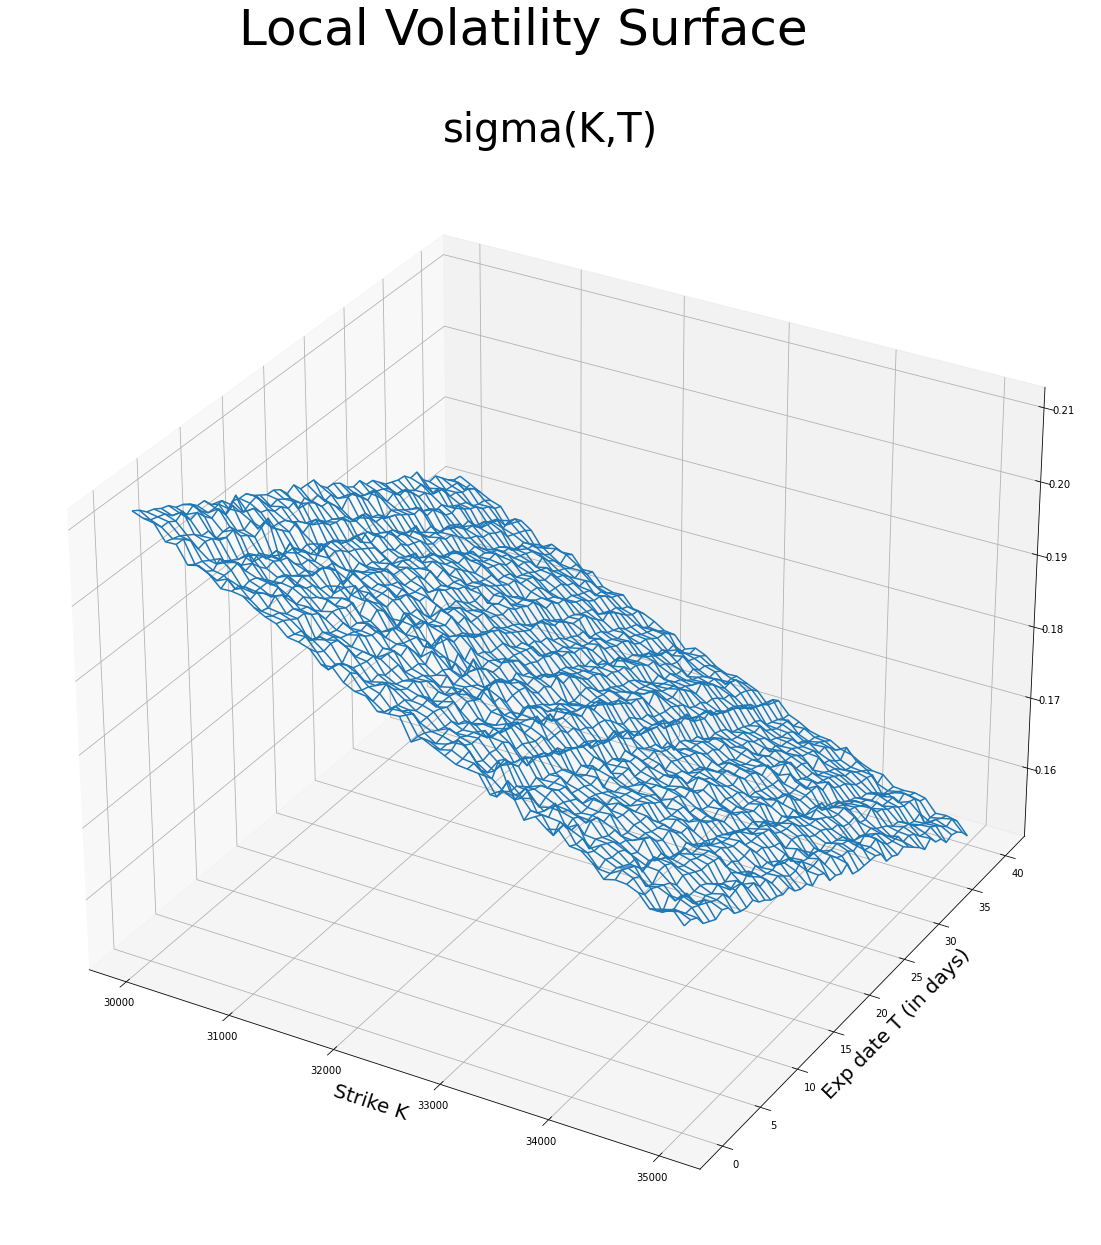

In [167]:
fig = plt.figure(figsize=(30,20))
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(X, Y, Z)
fig.suptitle('Local Volatility Surface', fontsize=50)
plt.title('sigma(K,T)', fontsize = 40)
plt.xlabel('Strike K', fontsize=20)
plt.ylabel('Exp date T (in days)', fontsize=20)
plt.savefig('VolLoc_wireframe.jpg')

plt.show()

In [138]:
#!code .
#!ls

## Calcul des vol impli

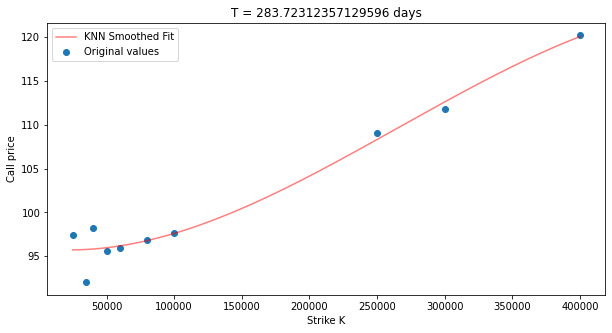

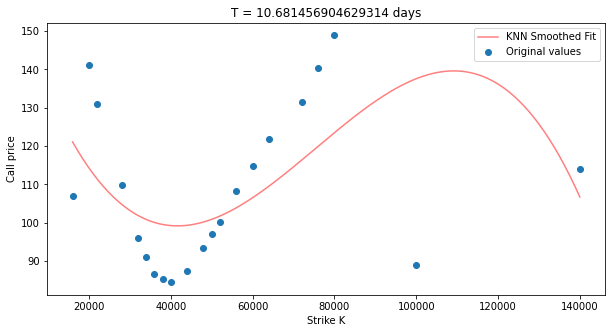

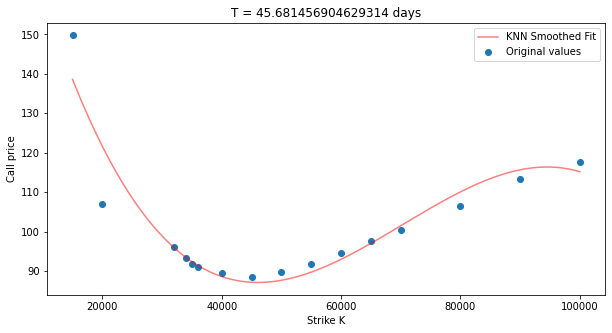

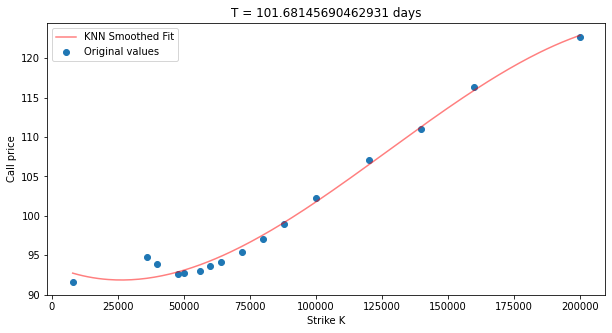

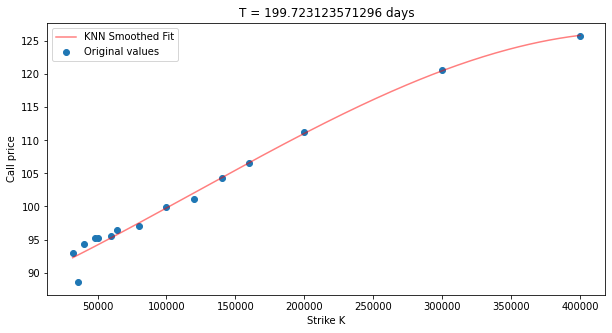

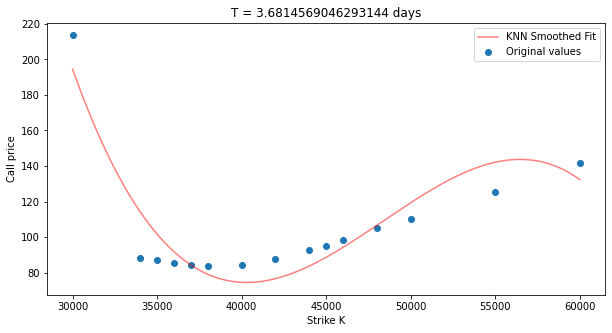

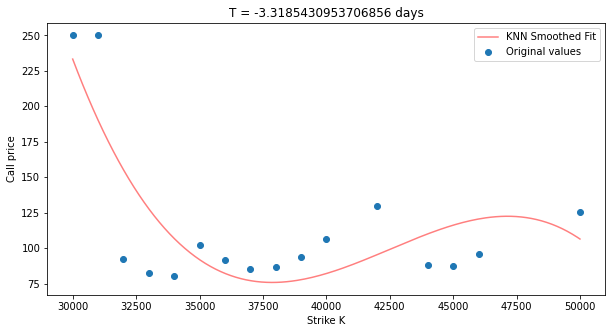

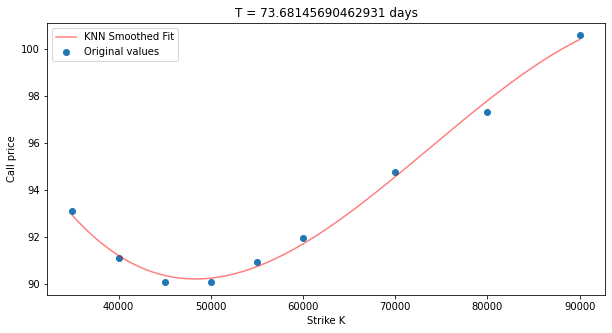

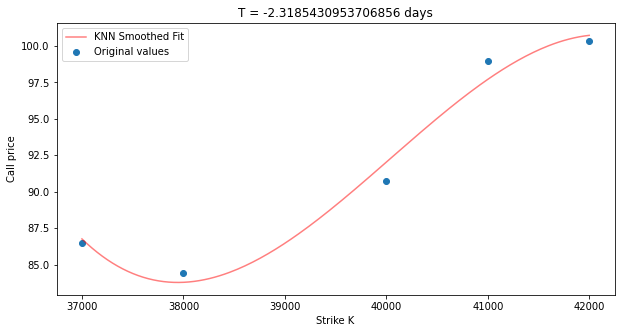

In [139]:
btc_data = btc_call

res = []
for i in list(btc_data['_T']):
    if i not in res:
        res.append(i)

plt.rcParams["figure.figsize"] = (10,5)

for T in res:
    
    X = btc_data[btc_data._T == T].K
    
    Y = btc_data[btc_data._T == T].mid_iv
    

    plt.xlabel('Strike K')
    plt.ylabel('Call price')
    plt.title('T = {} days'.format(T))
    


    nb_degree = 3
    
    polynomial_features = PolynomialFeatures(degree = nb_degree)
    X_TRANSF = polynomial_features.fit_transform(X.values.reshape(-1,1))
    model = LinearRegression()
    model.fit(X_TRANSF, Y.values.reshape(-1,1))
    
    X_NEW = X.values.reshape(-1,1)
    
    X_NEW = np.linspace(min(list(X)), max(list(X)), num=int(200)).reshape(-1,1)
    
    X_NEW_TRANSF = polynomial_features.fit_transform(X_NEW)
    Y_NEW = model.predict(X_NEW_TRANSF)
    
    
    
    
    plt.plot(X_NEW, Y_NEW, c='r', alpha=0.50, label='KNN Smoothed Fit')
    plt.scatter(X, Y, label = "Original values") #label='Mid Implied Volatility')
    plt.legend()
    plt.show()

In [169]:
class Call:
    def __init__(self,df):
        
        self.model_price = LinearRegression()
        self.model_iv = LinearRegression()



        self.polynomial_features = PolynomialFeatures(degree = 3)
        
        x = df[['_T','K']].astype(float)
        c = df['mid'].astype(float)      #ou last_price ?
        iv= df['mid_iv'].astype(float)
        
        
        x_transformed = polynomial_features.fit_transform(x)
        
        self.model_price.fit(x_transformed, c.values.reshape(-1,1))
        self.model_iv.fit(x_transformed, iv.values.reshape(-1,1))
        
        self.S0 = list(df['S'])[0]
        #print('S0 = {}'.format(self.S0))
        
    def C(self,K,T):
        #x = pd.DataFrame(np.array([K],[T]), columns = ['K','_T'])

        d = { '_T': [T], 'K': [K]}
        x = pd.DataFrame(data=d)

        X_NEW = self.polynomial_features.fit_transform(x)
        
        return float(np.squeeze(self.model_price.predict(X_NEW)))
    
    def sigma(self,K,T):
        #x = pd.DataFrame(np.array([K],[T]), columns = ['K','_T'])

        d = { '_T': [T], 'K': [K]}
        x = pd.DataFrame(data=d)

        X_NEW = self.polynomial_features.fit_transform(x)
        
        return float(np.squeeze(self.model_iv.predict(X_NEW)))
    

In [170]:
K_min = 37000
K_max = 150000
n_K = 50
T_min = 0
T_max = 100
n_T = 50

call = Call(btc_call)
print(call.S0)

Ks = np.linspace(K_min,K_max,n_K)
Ts = np.linspace(T_min,T_max,n_T)

38890.92


In [171]:
X, Y = np.meshgrid(Ks, Ts)

start = time.process_time()

Z = np.vectorize(call.sigma)(X,Y)
#Z = np.vectorize(local_vol)(call.C,X,Y)

print("calculé en {}s".format(time.process_time()-start))
print(Z)

calculé en 12.153115999999955s
[[108.75089757 108.69794527 108.6646629  ... 123.44951372 124.04932689
  124.65699602]
 [108.22416323 108.17089205 108.13727486 ... 122.89057196 123.48931756
  124.09590319]
 [107.70874169 107.65513472 107.62116582 ... 122.3421489  122.93981002
  123.54529526]
 ...
 [ 94.47016467  94.38396039  94.31667736 ... 106.796608   107.32798093
  107.86646114]
 [ 94.35824169  94.27092443  94.20251248 ... 106.61515481 107.14466607
  107.68126868]
 [ 94.25254934  94.16410219  94.09454443 ... 106.43913815 106.96677084
  107.50147895]]


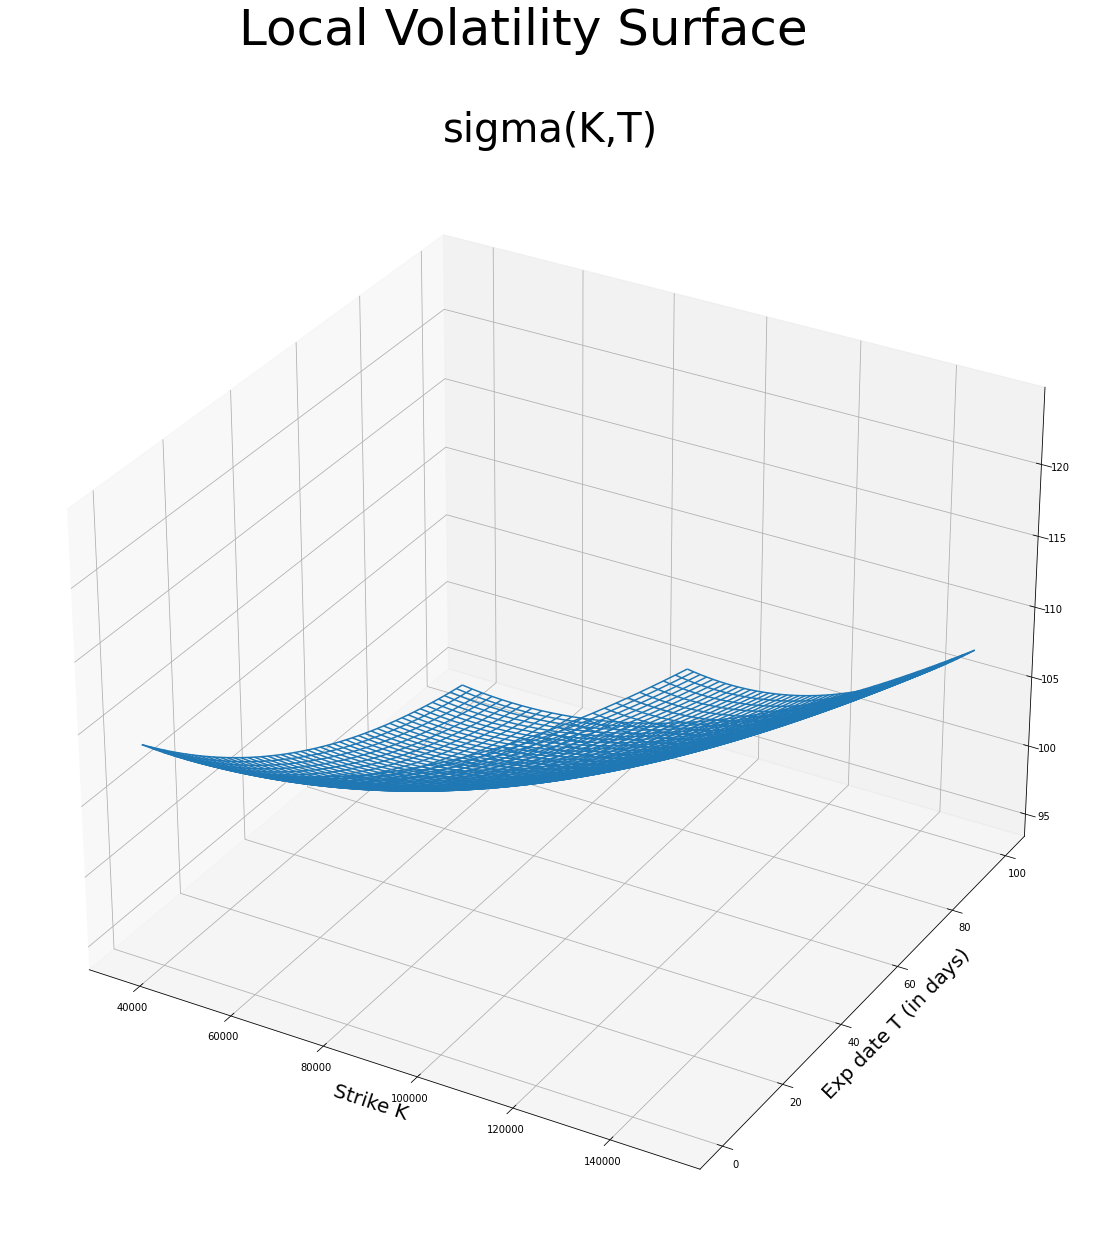

In [172]:


fig = plt.figure(figsize=(30,20))
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(X, Y, Z)
fig.suptitle('Implied Volatility Surface', fontsize=50)
plt.title('IV(K,T)', fontsize = 40)
plt.xlabel('Strike K', fontsize=20)
plt.ylabel('Exp date T (in days)', fontsize=20)
plt.savefig('IV_wireframe.jpg')

plt.show()